In [1]:
from astropy.io import fits
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.integrate import simps
from sklearn.neighbors import KernelDensity
import arviz as az
import glob

In [2]:
def plt_style():
    plt.rcParams.update({
                        'lines.linewidth':1.0,
                        'lines.linestyle':'-',
                        'lines.color':'black',
                        'font.family':'serif',
                        'font.weight':'normal',
                        'font.size':13.0,
                        'text.color':'black',
                        'text.usetex':True,
                        'axes.edgecolor':'black',
                        'axes.linewidth':1.0,
                        'axes.grid':False,
                        'axes.titlesize':'x-large',
                        'axes.labelsize':'x-large',
                        'axes.labelweight':'normal',
                        'axes.labelcolor':'black',
                        'axes.formatter.limits':[-4,4],
                        'xtick.major.size':7,
                        'xtick.minor.size':4,
                        'xtick.major.pad':8,
                        'xtick.minor.pad':8,
                        'xtick.labelsize':'medium',
                        'xtick.minor.width':1.0,
                        'xtick.major.width':1.0,
                        'ytick.major.size':7,
                        'ytick.minor.size':4,
                        'ytick.major.pad':8,
                        'ytick.minor.pad':8,
                        'ytick.labelsize':'medium',
                        'ytick.minor.width':1.0,
                        'ytick.major.width':1.0,
                        'legend.numpoints':1,
                        #'legend.fontsize':'x-large',
                        'legend.shadow':False,
                        'legend.frameon':False})


# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)




In [3]:
from scipy import interpolate

#Define number of H0 bins
nh0bins = 500
edg=np.linspace(20,140,num=nh0bins)


def cl_range(x,post,cl=0.68):
    edg=np.linspace(20,140,num=nh0bins)
    interp=interpolate.interp1d(x, post,fill_value="extrapolate")
    mypost=interp(edg)
    
    cdf=np.cumsum(mypost)
    cdf /= cdf[-1]
    # extapolation is almost certainly wrong, but is useful to see why it fails
    interp=interpolate.interp1d(cdf,edg, fill_value="extrapolate")
    l = (1.0-cl)*0.5
    u = 1.0-l
    lower = interp(l)
    upper = interp(u) #[()]
    peak = edg[np.argmax(mypost)]
    
    return peak, upper, lower # upper_err, lower_err

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [4]:
#Work w LVC posterior

l = np.genfromtxt('LVC_posterior_GW170817.txt')
lhist, xedges = np.histogram(l,bins=nh0bins,density=True)
lhat_old = savgol_filter(lhist, 51, 3)


lhat = lhat_old*xedges[:-1]

norm = simps(lhat,xedges[:-1])

lhat = lhat /norm

In [5]:
#Compute as asked by the IRs


def cl_around_mode(myedg,mypr):

    edg=np.linspace(20,140,num=nh0bins)
    interp=interpolate.interp1d(myedg, mypr,fill_value="extrapolate")
    myprob=interp(edg)

    peak = edg[np.argmax(myprob)]
    idx_sort_up=np.argsort(myprob)[::-1]
    #print(idx_sort_up)
    #norm = simps(lhat_cn,xedges_cn[:-1])
    i=0
    bins=[]
    integr=0.

    maxh0=100.
    b_num_max=np.where(edg>maxh0)[0].min()

    bmax=idx_sort_up[0]

    while(bmax<b_num_max):
        if (idx_sort_up[i]<b_num_max):
            bins.append(idx_sort_up[i])
            bmin= min(bins)
            bmax= max(bins)
        else:
            break
        i+=1


    while (integr<0.68):

        if (myprob[bmax+1]>myprob[bmin-1]):
            #print("Adding ",bmax_lo+1)
            bmax = bmax+1
            bmin = bmin
            #bins_now_good = np.append(bins_now_good,
            bins.append(bmax+1)
        else:
            #print("Adding ",bmin-1)
            bmin = bmin-1
            bmax = bmax
            bins.append(bmin-1)
        integr = simps(myprob[bmin:bmax],edg[bmin:bmax])

    print(integr, edg[bmin], edg[bmax])
    
    return  edg[bmin], edg[bmax]

    

In [6]:

#Constantina's samples

#l = np.genfromtxt('/Users/palmese/work/GW/Dark_sirens/plots/LVC_posterior_GW170817.txt')
cn=np.genfromtxt('GW170817_constantina_model2_flatH0prior20_140.txt')

lhist_cn, xedges_cn = np.histogram(cn,bins=2000,density=True)
lhat_old_cn = savgol_filter(lhist_cn, 51, 3)

lhat_cn = lhat_old_cn*xedges_cn[:-1]

norm_cn = simps(lhat_cn,xedges_cn[:-1])

lhat_cn = lhat_cn /norm_cn

X_plot=np.linspace(20,140,num=nh0bins)

kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(cn[:,None])
log_dens = kde.score_samples(X_plot[:, np.newaxis])


70.50100200400801 21.80624137480561 6.255655864785126
170817 HPD:  68.81763527054107 17.29878816192155 7.638243176275893


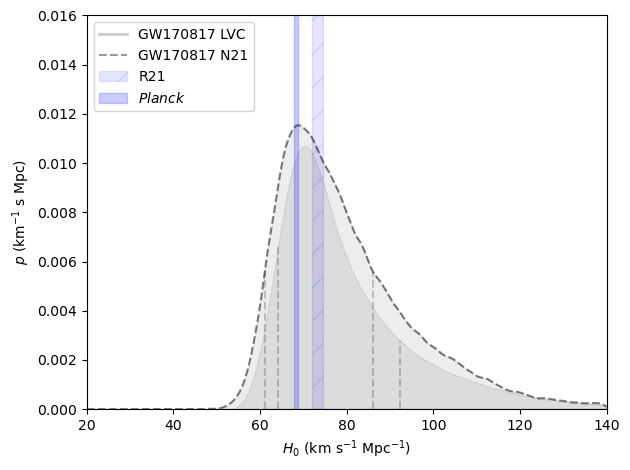

In [7]:
plt.clf()



#Combined w 170817
use_lvc=True
if use_lvc:
    
    plt.fill_between(xedges[:-1],np.zeros(xedges[:-1].shape[0]),lhat/3.8,color='k',alpha=0.07)
    
    #Remake 170817 interval

    color='k'
    factor=3.8
    p_max, p_hi, p_lo = cl_range(xedges[:-1],lhat)
    px_max = find_nearest(xedges[:-1],p_max)
    px_hi = find_nearest(xedges[:-1],p_hi)
    px_lo = find_nearest(xedges[:-1],p_lo)
    plt.plot([200,200],[0,0],c=color,zorder=100,alpha=0.2,lw=2, label='GW170817 LVC')
    plt.plot([p_lo,p_lo],[0,lhat[px_lo]/factor], '--',c=color,zorder=50,alpha=0.2)
    plt.plot([p_hi,p_hi],[0,lhat[px_hi]/factor], '--',c=color,zorder=50,alpha=0.2)
    print(p_max,p_hi-p_max, p_max-p_lo)
    

    #Now Constantina's 

    factor=3.
    plt.fill_between(X_plot,np.zeros(X_plot.shape[0]), np.exp(log_dens)/factor,color='k',alpha=0.07)
    cn_lo,cn_hi = az.hdi(cn, hdi_prob=0.68)
    px_hi = find_nearest(X_plot,cn_hi)
    px_lo = find_nearest(X_plot,cn_lo)
    plt.plot([200,200],[0,0],'--',c='k',zorder=100,alpha=0.4, label='GW170817 N21')
    plt.plot([cn_lo,cn_lo],[0,np.exp(log_dens[px_lo])/factor], '--',c='k',zorder=100,alpha=0.2)
    plt.plot([cn_hi,cn_hi],[0,np.exp(log_dens[px_hi])/factor], '--',c='k',zorder=100,alpha=0.2)
    p17_max, p17_hi, p17_lo = cl_range(X_plot,np.exp(log_dens))
    #print("170817 ETI: ",p17_lo,p17_hi,p17_max,p17_hi-p17_max, p17_max-p17_lo)
    print("170817 HPD: ",p17_max,cn_hi-p17_max, p17_max-cn_lo)



factor=3.
plt.plot(X_plot, np.exp(log_dens)/factor,'--',color='k',alpha=0.5)
p17_max, p17_hi, p17_lo = cl_range(edg,np.exp(log_dens))
px_hi = find_nearest(edg,p17_hi)
px_lo = find_nearest(edg,p17_lo)
#plt.plot([p17_lo,p17_lo],[0,np.exp(log_dens[px_lo])/factor], ':',c='k',zorder=100)
#plt.plot([p17_hi,p17_hi],[0,np.exp(log_dens[px_hi])/factor], ':',c='k',zorder=100)


plt.fill_between(np.array([73.2-1.3,73.2 +1.3]),np.array([0.,0.0]),np.array([0.016,0.016]), color='#0000ff',alpha=0.1,hatch="/",label='R21',zorder=0)
plt.fill_between(np.array([68.82,67.90]),np.array([0.,0.0]),np.array([0.016,0.016]), color='#0000ff',alpha=0.2,label='$Planck$',zorder=0)

    
plt.xlim(20,140)
plt.ylim(0,0.016)
plt.xlabel(r'$H_0~{\rm (km ~s^{-1}~Mpc^{-1})}$')
plt.ylabel(r'$p ~{\rm (km^{-1} ~s~Mpc)}$')
plt.tight_layout()
plt.legend(loc='upper left',fontsize=10)
plt.savefig('posteriors_170817.png',dpi=200)


